In [1]:
 # for google colaab setup
import sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required libraries for ViT and other dependencies
!pip install seaborn
!pip install transformers
!pip install tensorflow
!pip install datasets
!pip install matplotlib
!pip install Pillow
!pip install numpy
!pip install tensorflow-hub
!pip install scikit-learn
!pip install tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
%cd /content/drive/MyDrive/projects/sign-language-image-detection
!pip install virtualenv
!pip install -r requirements.txt
!python -m ipykernel install --user --name=sl_detection --display-name "SL Detection"

/content/drive/MyDrive/projects/sign-language-image-detection
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 15.9 MB/s eta 0:00:00
Installed kernelspec sl_detection in /root/.local/share/jupyter/kernels/sl_detection


In [4]:
# Install required packages (add `--upgrade` to ensure the latest versions)
!pip install --upgrade transformers datasets torch torchvision accelerate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 63.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1


In [11]:
!pip uninstall transformers


Found existing installation: transformers 4.48.0
Uninstalling transformers-4.48.0:
  Would remove:
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.10/dist-packages/transformers-4.48.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/transformers/*
Proceed (Y/n)? y
  Successfully uninstalled transformers-4.48.0


In [12]:
!pip install transformers


  Using cached transformers-4.48.0-py3-none-any.whl.metadata (44 kB)
Using cached transformers-4.48.0-py3-none-any.whl (9.7 MB)


In [ ]:
from datasets import load_dataset, DatasetDict
from transformers import DeiTImageProcessor,DeiTForImageClassification,TrainingArguments,Trainer

from torchvision.transforms import Normalize, ToTensor, Resize
import torch
from torch.utils.data import DataLoader


In [51]:
# Load the ASL Sign Language Alphabets dataset from Hugging Face
dataset_name = "Marxulia/asl_sign_languages_alphabets_v03"
dataset = load_dataset(dataset_name)

In [58]:
# Calculate sizes for train, validation, and test splits
train_size = int(0.7 * len(dataset['train']))  # 70% for training
val_size = int(0.1 * len(dataset['train']))    # 10% for validation
test_size = len(dataset['train']) - train_size - val_size  # Remaining for testing

# Split dataset into train, validation, and test sets
train_ds = dataset['train'].select(range(0, train_size))
val_ds = dataset['train'].select(range(train_size, train_size + val_size))
test_ds = dataset['train'].select(range(train_size + val_size, len(dataset['train'])))
dataset_splits = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds
})



# Load the DeiT image processor
model_name = "facebook/deit-tiny-distilled-patch16-224"
processor = DeiTImageProcessor.from_pretrained(model_name)

# Define image normalization and resizing
image_mean, image_std = processor.image_mean, processor.image_std
normalize = Normalize(mean=image_mean, std=image_std)
image_size = processor.size["height"]
resize = Resize((image_size, image_size))

# Define transformation function
def apply_transforms(examples):
    examples["pixel_values"] = [
        normalize(ToTensor()(resize(image.convert("RGB")))) for image in examples["image"]
    ]
    return examples


# Apply transformations to dataset splits
dataset_splits["train"].set_transform(apply_transforms)
dataset_splits["validation"].set_transform(apply_transforms)
dataset_splits["test"].set_transform(apply_transforms)

In [44]:
print(image_mean)

[0.485, 0.456, 0.406]


In [64]:
import torch
from torch.utils.data import DataLoader

# Custom collate function for batching
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# Set up DataLoader for training and validation
train_dl = DataLoader(train_ds, collate_fn=collate_fn, batch_size=16)
val_dl = DataLoader(val_ds, collate_fn=collate_fn, batch_size=16)

In [59]:
# Map label IDs to labels
id2label = {id: label for id, label in enumerate(train_ds.features["label"].names)}
label2id = {label: id for id, label in id2label.items()}

# Load the DeiT model
model = DeiTForImageClassification.from_pretrained(
    model_name,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=False
)

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:

# Define training arguments
train_args = TrainingArguments(
    output_dir="output-models-deit",
    save_total_limit=2,
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",       # Save the model at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="logs",
    remove_unused_columns=False,
    report_to="none",  # Disable W&B logging
    local_rank=-1       # Disable distributed training
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [65]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=dataset_splits["train"],
    eval_dataset=dataset_splits["validation"],
    tokenizer=processor,
    data_collator=collate_fn


)

<ipython-input-65-d46be23ea7a5>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [66]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,4.814891
2,1.648700,5.149036
3,0.261900,5.288371
4,0.037600,5.973335
5,0.005500,6.051715
6,0.001200,6.297840
7,0.000600,6.454474
8,0.000400,6.626317
9,0.000300,6.689054
10,0.000300,6.893559


TrainOutput(global_step=9520, training_loss=0.10281269405457336, metrics={'train_runtime': 1172.4315, 'train_samples_per_second': 129.833, 'train_steps_per_second': 8.12, 'total_flos': 7.602406668664013e+17, 'train_loss': 0.10281269405457336, 'epoch': 20.0})

In [25]:
# Evaluate the model on the test set
outputs = trainer.predict(dataset_splits["test"])


print(outputs.metrics)

{'test_loss': 6.03462028503418, 'test_runtime': 10.1553, 'test_samples_per_second': 214.174, 'test_steps_per_second': 6.696}


ValueError: The number of FixedLocator locations (24), usually from a call to set_ticks, does not match the number of labels (26).

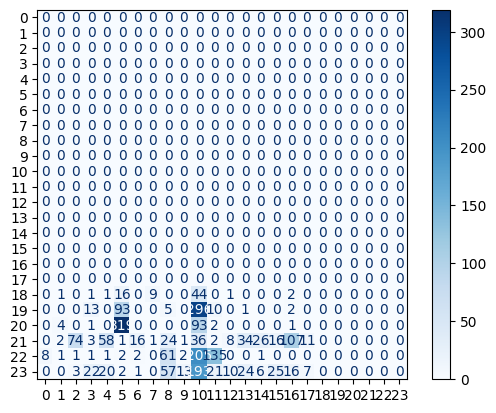

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions and true labels
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

# Get label names
labels = train_ds.features["label"].names

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.show()


In [ ]:
# Calculate the recall scores for each class
recall = recall_score(y_true, y_pred, average=None)

# Print the recall for each class
print("\nRecall Scores:")
for label, score in zip(labels, recall):
    print(f"Recall for {label}: {score:.2f}")